# Purpose
This example demonstrates extracting univariate effects computed by a centered parameter study from Dakota's HDF5 output and then plotting them.

The simulation that Dakota runs is a simple analytical model of a cantilever beam. The variables studied are:

* **R**: yield strength
* **E**: Young's modulus
* **X**: horizontal load
* **Y**: vertical load
* **w**: width
* **t**: thickness

The length and other pertinent material properties of the beam are fixed.

The responses are the cross-sectional **area** of the beam, the **stress**, and the tip **displacement**.

To (re)generate the results output, run dakota -i dakota_centered.in.

---
Begin by importing `h5py` and other required modules.

In [1]:
from __future__ import print_function
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt

/home/jasteph/anaconda/envs/python35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The goal is to produce one plot for each of the three responses, area, stress, and displacement that show all of the
univariate effects. The data we want are contained in the variable_slices group. Within this group are separate groups for each variable in the. These contain two datasets:

* `<variable descriptor>/steps`: The univariate steps for the variable, including the center point
* `<variable descriptor>/responses`: A 2D dataset for all the responses, including the center point

The approach is:
1. Open the Dakota results file in read-only mode using the `h5py.File()` method.
2. Iterate over the responses
3. For each response, plot the response vs the variable

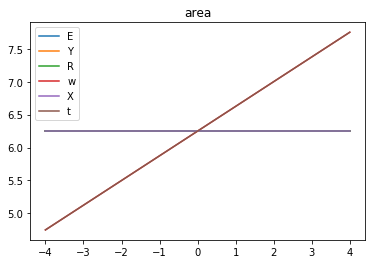

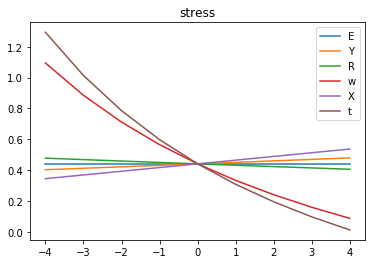

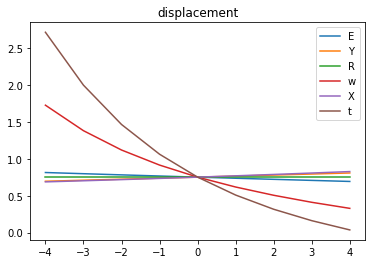

In [33]:
# Use a context manager (i.e. "with") to ensure the file is closed properly
with h5py.File("dakota_results.h5","r") as h:
    # For convenience, create a Group object
    # that refers to the results we are interested in.
    results = h["/methods/NO_ID/execution:1/"]
    ### iterate over the response labels ##
    # We need the response descriptors. We could get them from the dimension scale on 
    # variable_slices/<some variable>/responses, but they are also available from 
    # parameter_sets/responses, and in that case we don't need to know or use a variable label.
    
    # The descriptors are on the 1st dimension of the dataset, and they are the 0th scale on that dimension.
    # Hence, we iterate over dims[1][0].
    for i, response in enumerate(results["parameter_sets/responses"].dims[1][0]):
        plt.figure(i+1)
        plt.title(response)
        # iterate the contents of the variable_slices group, which are the variable groups,
        # and plot. The items() method yields a 2-tuple that contains the name of an HDF5 object and
        # the object itself. This is analogous to a Python dictionary.
        for label, group in results["variable_slices"].items():
            # We could plot the responses against the variable values in the 'steps' dataset. However,
            # to place all the effects on the same plots, it's preferable to "normalize" by number of steps.
            num_steps = group["steps"].shape[0]  # just like .shape on a numpy array
            steps = np.arange(-(num_steps//2), num_steps//2+1)       
            plt.plot(steps, group["responses"][:,i], label=label)
        plt.legend() # Add a legend
     

## Conclusions
* The effects of each variable on area are hard to distinguish because many of the plots lie on top of one another. However, this is what we would expect; the area is just the product of the width and thickness, and no other variables (should) affect it.

* The thickness and width also have the most pronounced effects on the stress and displacement.

